In [ ]:
from sklearn.preprocessing import StandardScaler
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from skimage.transform import resize
import pandas as pd
from matplotlib.image import imread
from skimage.io import imread_collection
from PIL import Image
import seaborn as sns
from sklearn import decomposition, preprocessing, svm
import sklearn.metrics as metrics #confusion_matrix, accuracy_score
from time import sleep 
from tqdm.notebook import tqdm
import os
sns.set()

In [5]:
#Dataset
very_mild = glob(r"C:\Users\Safa Abubakar\Downloads\Alzheimer_MRI_4_classes_dataset-20250324T154737Z-001\Alzheimer_MRI_4_classes_dataset\VeryMildDemented")
mild = glob(r"C:\Users\Safa Abubakar\Downloads\Alzheimer_MRI_4_classes_dataset-20250324T154737Z-001\Alzheimer_MRI_4_classes_dataset\MildDemented")
moderate = glob(r"C:\Users\Safa Abubakar\Downloads\Alzheimer_MRI_4_classes_dataset-20250324T154737Z-001\Alzheimer_MRI_4_classes_dataset\ModerateDemented")
non = glob(r"C:\Users\Safa Abubakar\Downloads\Alzheimer_MRI_4_classes_dataset-20250324T154737Z-001\Alzheimer_MRI_4_classes_dataset\NonDemented")

C:\Users\Safa Abubakar\Downloads\Alzheimer_MRI_4_classes_dataset-20250324T154737Z-001\Alzheimer_MRI_4_classes_dataset\NonDemented\1 (100).jpg
One of the data in Non Alzheimer Folder
Image shape:(208, 176)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

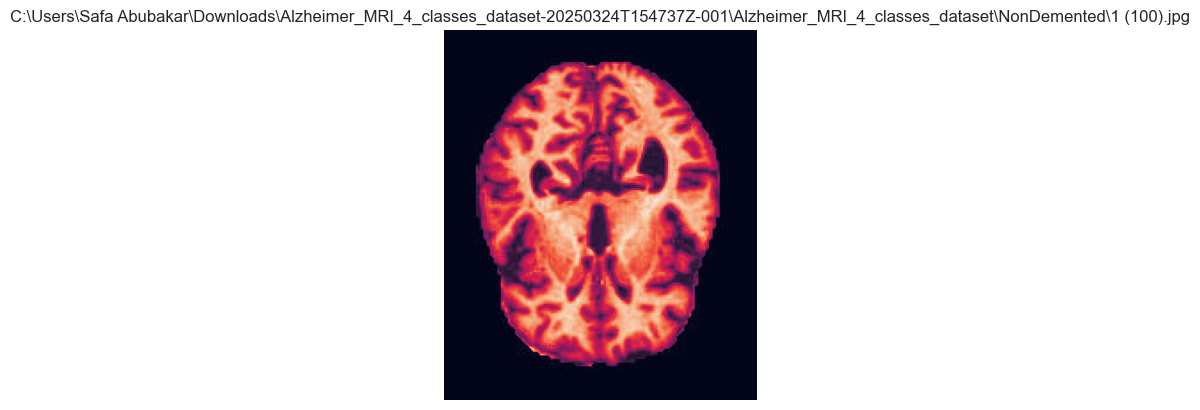

In [8]:
from glob import glob
print(non[1])
def view_image(directory):
    img = mpimg.imread(directory)
    plt.imshow(img)
    plt.title(directory)
    plt.axis('off')
    print(f'Image shape:{img.shape}')
    return img

print('One of the data in Non Alzheimer Folder')
view_image(non[1])

Alzheimer Patient's Brain
Image shape:(208, 176)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

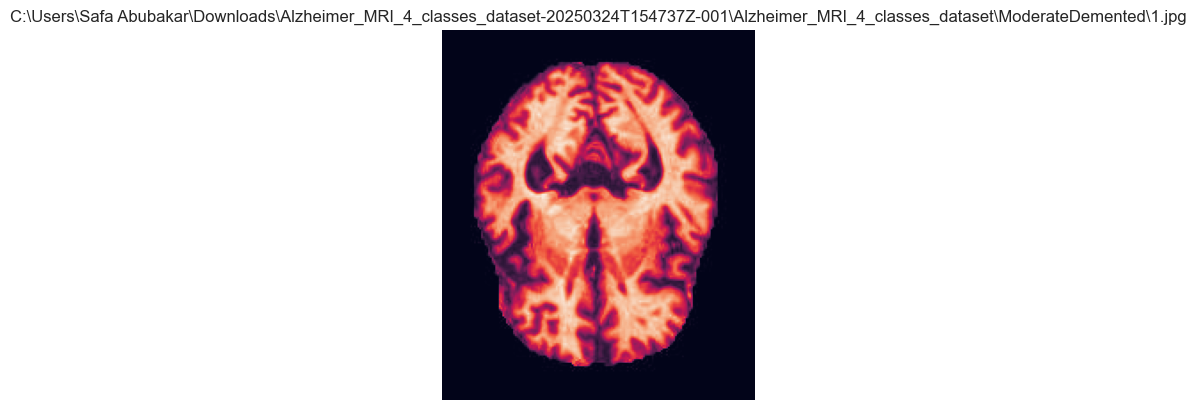

In [9]:
print('Alzheimer Patient\'s Brain')
view_image(moderate[1])

### VGG16 (CNN) for Alzheimer Detection

In [ ]:
import cv2
dim = (128, 128) 

def extract_feature(dir_path):
    img = mpimg.imread(dir_path)
    img = img / 255.0  
    img = resize(img, (128, 128, 3))  
    img = np.reshape(img, (128, 384))
    return img

non_ALZ = [extract_feature(filename) for filename in non]
vmild_ALZ = [extract_feature(filename) for filename in very_mild]
mild_ALZ = [extract_feature(filename) for filename in mild]
moderate_ALZ = [extract_feature(filename) for filename in moderate]
ALZ = vmild_ALZ + mild_ALZ + moderate_ALZ
all_data = np.concatenate((np.array(non_ALZ),np.array(ALZ)))
all_data = all_data.reshape(all_data.shape[0], np.product(all_data.shape[1:]))

scaler = StandardScaler()
scaler.fit(all_data)
X = scaler.transform(all_data)
from sklearn.model_selection import train_test_split
y = [0] * len(non_ALZ) + [1] * len(ALZ)
X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.2)

def to_rgb(img):
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
    img_rgb = np.asarray(np.dstack((img, img, img)), dtype=np.uint8)
    return img_rgb

rgb_list = []
for i in range(len(X_train)):
    rgb = to_rgb(X_train[i])
    rgb_list.append(rgb)

rgb_arr = np.stack([rgb_list],axis=4)
rgb_arr_to_3d = np.squeeze(rgb_arr, axis=4)
print(rgb_arr_to_3d.shape)

(5120, 128, 128, 3)


In [ ]:

rgb_list_test = []
for i in range(len(X_test)):
    rgb = to_rgb(X_test[i])
    rgb_list_test.append(rgb)
   
rgb_arr_test = np.stack([rgb_list_test],axis=4)
rgb_arr_to_3d_test = np.squeeze(rgb_arr_test, axis=4)
print(rgb_arr_to_3d_test.shape)

(1280, 128, 128, 3)


In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Input, Dropout
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image

vgg16 = VGG16(weights = 'imagenet', input_shape = (128, 128, 3), include_top = False)
vgg16.summary()

vgg16.trainable = False
final_model = Sequential()
final_model.add(vgg16)
final_model.add(Flatten(name='flatten'))
final_model.add(Dense(2,activation = 'softmax', name = 'predictions'))
final_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

final_model.fit(rgb_arr_to_3d, np.array(y_train).reshape(-1,1), batch_size = 7, epochs = 10, verbose = 1)
final_model.fit(rgb_arr_to_3d_test, np.array(y_test).reshape(-1,1), batch_size = 7, epochs = 10, verbose = 1)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     